In [100]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import talib

from sklearn.metrics import classification_report,confusion_matrix,mean_absolute_error as mae, mean_absolute_percentage_error as mape
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import TimeSeriesSplit

from feature_engine.selection import DropFeatures
from feature_engine.datetime import DatetimeFeatures

import warnings
warnings.filterwarnings("ignore")

In [101]:
import xgboost as xgb
from sklearn.linear_model import Ridge

In [102]:
def getData(stockName,period,interval):
    return yf.download(tickers=stockName, period=period, interval=interval)

In [210]:
df=getData('EURUSD=X','1y','1h')['Close'].to_frame()

[*********************100%***********************]  1 of 1 completed


In [211]:
df['Close-1']=df['Close'].shift(1)
df=df.dropna()

In [212]:
df['diff']=df['Close']-df['Close-1']
df['label']=np.where(df['diff']>0,1,0)

In [213]:
df

,Close,Close-1,diff,label
Datetime,,,,
2022-06-09 16:00:00+01:00,1.066098,1.065303,0.000795,1
2022-06-09 17:00:00+01:00,1.065530,1.066098,-0.000568,0
2022-06-09 18:00:00+01:00,1.064056,1.065530,-0.001474,0
2022-06-09 19:00:00+01:00,1.063038,1.064056,-0.001018,0
2022-06-09 20:00:00+01:00,1.061571,1.063038,-0.001467,0
...,...,...,...,...
2023-06-09 11:00:00+01:00,1.076426,1.076079,0.000347,1
2023-06-09 12:00:00+01:00,1.077586,1.076426,0.001160,1
2023-06-09 13:00:00+01:00,1.077122,1.077586,-0.000464,0


In [214]:
df['sma'] = talib.SMA(df['Close'], timeperiod=20)
df['rsi'] = talib.RSI(df['Close'], timeperiod=14)
df['kama'] = talib.KAMA(df['Close'], timeperiod=10)

In [215]:
for i in ['Close','sma','rsi','kama']:
    for j in [3,4,5,6,7]:
        df[f'{i}_lag_{j}']=df[i].shift(j)

In [216]:
df=df.dropna().reset_index()

In [217]:
df

,Datetime,Close,Close-1,diff,label,sma,rsi,kama,Close_lag_3,Close_lag_4,...,rsi_lag_3,rsi_lag_4,rsi_lag_5,rsi_lag_6,rsi_lag_7,kama_lag_3,kama_lag_4,kama_lag_5,kama_lag_6,kama_lag_7
0,2022-06-10 18:00:00+01:00,1.052632,1.051967,0.000664,1,1.059258,20.537413,1.053335,1.053630,1.052964,...,18.499557,14.442828,12.421046,18.556537,22.200855,1.055457,1.056237,1.058176,1.061270,1.062289
1,2022-06-10 19:00:00+01:00,1.052521,1.052632,-0.000111,0,1.058799,20.355511,1.053125,1.052299,1.053630,...,16.786320,18.499557,14.442828,12.421046,18.556537,1.054406,1.055457,1.056237,1.058176,1.061270
2,2022-06-10 20:00:00+01:00,1.052410,1.052521,-0.000111,0,1.058307,20.163391,1.052957,1.051967,1.052299,...,16.378569,16.786320,18.499557,14.442828,12.421046,1.053594,1.054406,1.055457,1.056237,1.058176
3,2022-06-10 21:00:00+01:00,1.051857,1.052410,-0.000553,0,1.057748,19.188620,1.052700,1.052632,1.051967,...,20.537413,16.378569,16.786320,18.499557,14.442828,1.053335,1.053594,1.054406,1.055457,1.056237
4,2022-06-10 22:00:00+01:00,1.052632,1.051857,0.000775,1,1.057245,24.680007,1.052691,1.052521,1.052632,...,20.355511,20.537413,16.378569,16.786320,18.499557,1.053125,1.053335,1.053594,1.054406,1.055457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6178,2023-06-09 11:00:00+01:00,1.076426,1.076079,0.000347,1,1.078069,48.493651,1.077551,1.077935,1.078167,...,62.171037,64.850968,66.177441,64.136023,67.943978,1.078355,1.078375,1.078380,1.078381,1.078396
6179,2023-06-09 12:00:00+01:00,1.077586,1.076426,0.001160,1,1.078034,56.810137,1.077553,1.076658,1.077935,...,49.954594,62.171037,64.850968,66.177441,64.136023,1.078068,1.078355,1.078375,1.078380,1.078381
6180,2023-06-09 13:00:00+01:00,1.077122,1.077586,-0.000464,0,1.077953,53.113406,1.077540,1.076079,1.076658,...,45.578756,49.954594,62.171037,64.850968,66.177441,1.077708,1.078068,1.078355,1.078375,1.078380
6181,2023-06-09 14:00:00+01:00,1.077354,1.077122,0.000232,1,1.077918,54.699451,1.077534,1.076426,1.076079,...,48.493651,45.578756,49.954594,62.171037,64.850968,1.077551,1.077708,1.078068,1.078355,1.078375


In [249]:
X_df = df.drop(columns=['Close','Close-1','diff','label','Datetime','sma','rsi','kama'])
y_df = df['Close']

In [250]:
X = np.array(X_df)
y = np.array(y_df)

tscv = TimeSeriesSplit(n_splits=10)  # Specify the number of splits (number of folds)

# Perform time series cross-validation
scr = []
df_s = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgb.XGBRegressor()
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    scr.append(mape(y_test,preds))
    
    df_s.append(pd.DataFrame(y_test,preds).reset_index().rename(columns={'index':'Real',0:'Pred'}))
    
    

In [251]:
np.mean(scr)

0.005537708947729229

In [252]:
[i*100 for i in scr]

[0.4143848959666981,
 0.34019183777253964,
 1.5778511903287564,
 0.31096001701843956,
 0.524707379272058,
 1.3010831106509433,
 0.2504270280066482,
 0.18755661366056506,
 0.5041800116753687,
 0.12636686337721198]

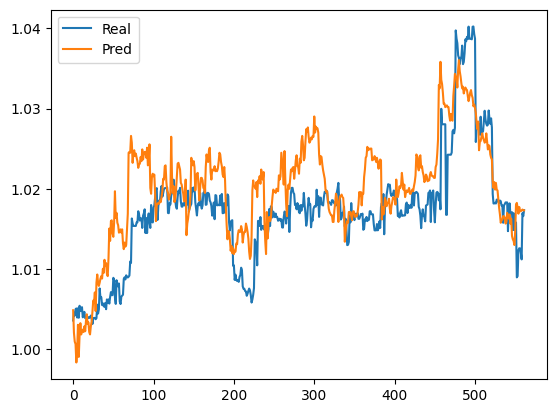

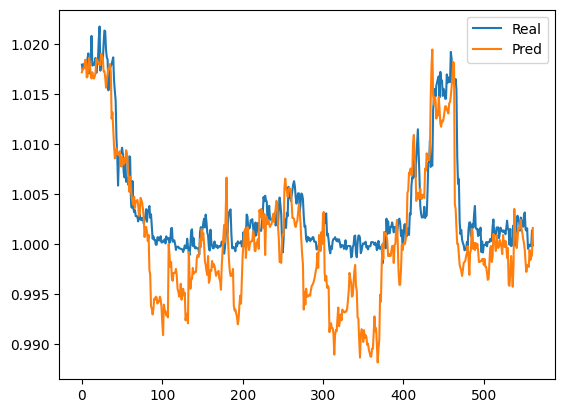

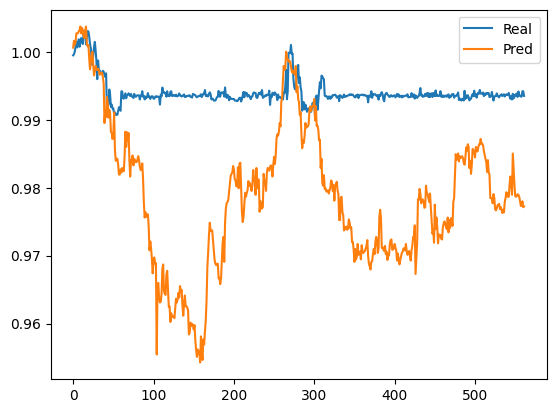

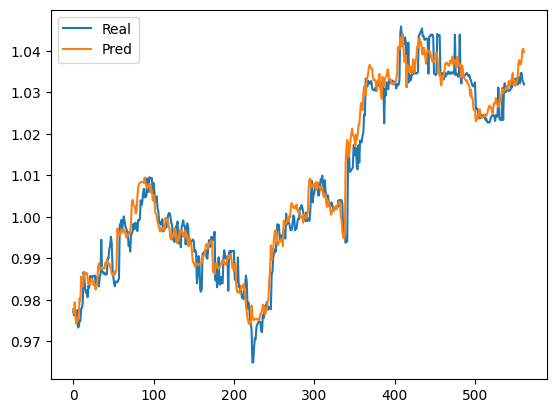

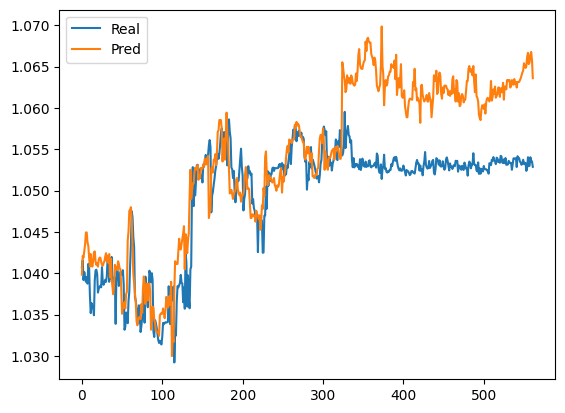

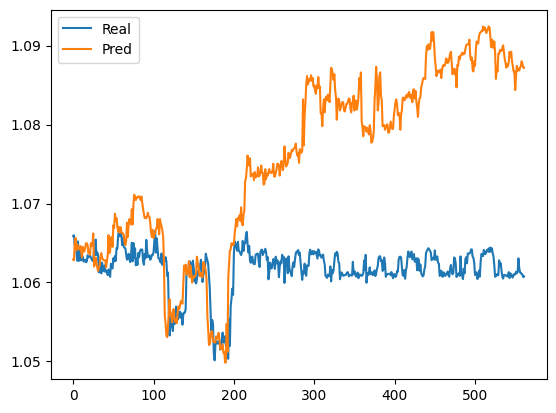

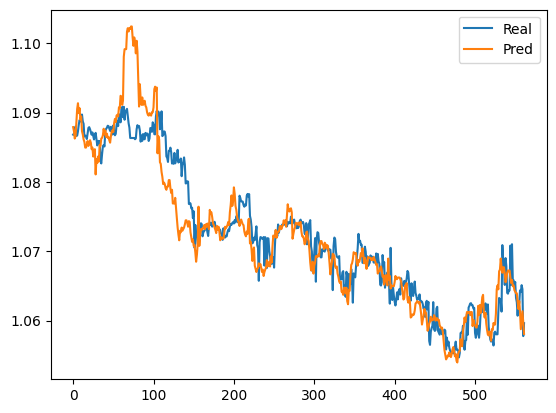

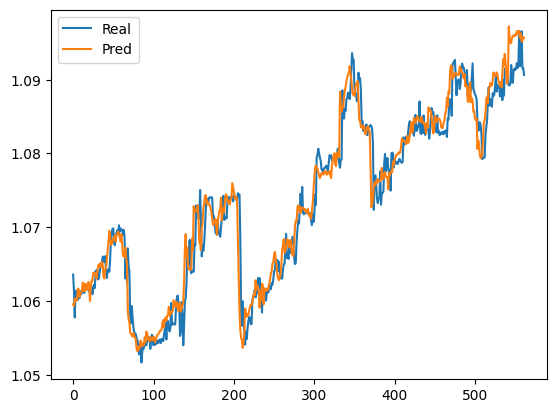

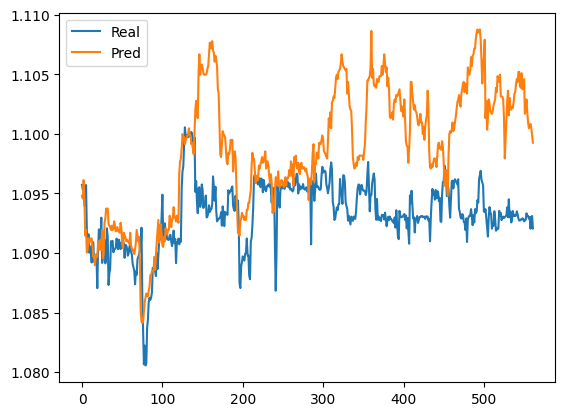

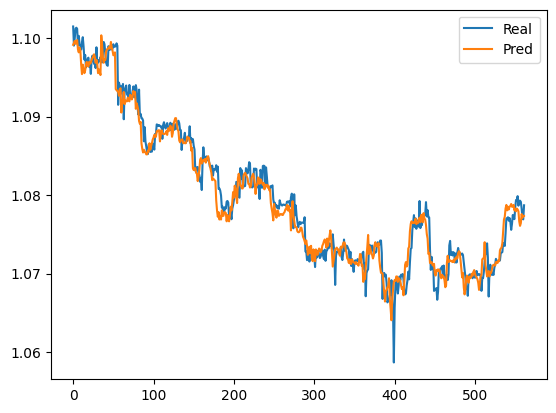

In [253]:
for i in df_s:
    i.plot()

In [254]:
rt=round(len(X_df)*0.6)
rv=rt+round(len(X_df)*0.2)

In [255]:
X_tr = X_df[:rt]
X_val = X_df[rt:rv]
X_ts = X_df[rv:]

y_tr = y_df[:rt]
y_val = y_df[rt:rv]
y_ts = y_df[rv:]

In [256]:
model = xgb.XGBRegressor()
model.fit(X_tr,y_tr)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [257]:
val_pred = model.predict(X_val)
test_pred = model.predict(X_ts)

In [258]:
mape(y_val,val_pred)

0.00322943195849325

In [259]:
mape(y_ts,test_pred)

0.009996025741270932

<Axes: >

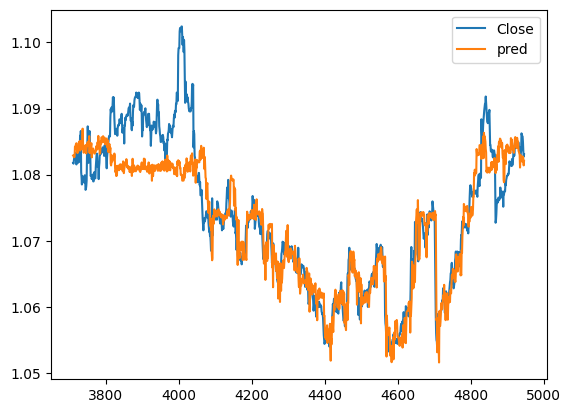

In [260]:
y_df=y_val.to_frame()
y_df['pred']=val_pred
y_df.plot()

<Axes: >

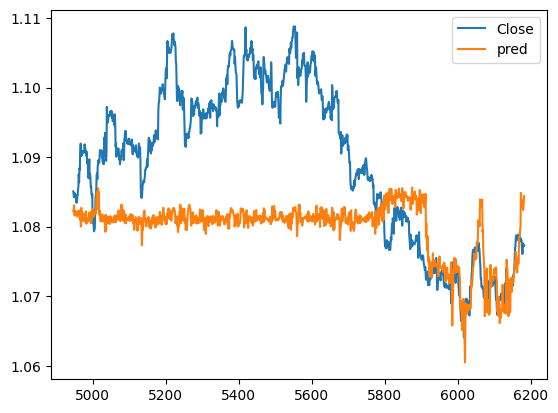

In [261]:
y_df=y_ts.to_frame()
y_df['pred']=test_pred
y_df.plot()